<a href="https://colab.research.google.com/github/GoriyashKashyap/Clustering_Project/blob/main/Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Problem Statement:**<br>
The main objective of this task is to segment customers into distinct groups based on their purchasing behavior, demographics, and spending patterns. By identifying patterns in customer behavior, the business can create targeted marketing strategies, improve customer satisfaction, and enhance revenue

**Importing Libraries**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
import warnings
warnings.filterwarnings('ignore')
sns.set(style="whitegrid")

**Import Dataset**

In [ ]:
import kagglehub
import os

# Download latest version
path = kagglehub.dataset_download("abdallahwagih/mall-customers-segmentation")
print(f"Dataset downloaded to: {path}")

csv_file_name = 'Mall_Customers.csv'
csv_file_path = os.path.join(path, csv_file_name)

100%|██████████| 1.56k/1.56k [00:00<00:00, 1.25MB/s]

Extracting files...
Dataset downloaded to: /root/.cache/kagglehub/datasets/abdallahwagih/mall-customers-segmentation/versions/1


In [ ]:
df = pd.read_csv(csv_file_path)

display(df.head())

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


**EDA :**

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Genre                   200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [ ]:
df.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


**Unique Values for Categorical Varibles**




In [ ]:
for column in df.columns:
    if df[column].dtype == object:
        print(column.upper(),': ',df[column].nunique())
        print(df[column].value_counts().sort_values())
        print("\n")

GENRE :  2
Genre
Male       88
Female    112
Name: count, dtype: int64




There is no need of the ID column

In [ ]:
df = df.drop(['CustomerID'], axis=1)

Coverting categorical to Dummy Variables

In [ ]:
df = pd.get_dummies(df, columns=['Genre'], drop_first=True)

df.head()

,Age,Annual Income (k$),Spending Score (1-100),Genre_Male
0,19,15,39,True
1,21,15,81,True
2,20,16,6,False
3,23,16,77,False
4,31,17,40,False


In [ ]:
# Convert boolean columns to integers (True to 1, False to 0)
for col in df.columns:
    if df[col].dtype == 'bool':
        df[col] = df[col].astype(int)

In [ ]:
df.head()

,Age,Annual Income (k$),Spending Score (1-100),Genre_Male
0,19,15,39,1
1,21,15,81,1
2,20,16,6,0
3,23,16,77,0
4,31,17,40,0


**Check For missing Values**

In [ ]:
df.isnull().sum()

,0
Age,0
Annual Income (k$),0
Spending Score (1-100),0
Genre_Male,0


**Check For Duplicates**

In [ ]:
dups = df.duplicated()
print('Number of duplicate rows = %d' % (dups.sum()))

df[dups]

Number of duplicate rows = 0


,Age,Annual Income (k$),Spending Score (1-100),Genre_Male


**Univariate Analysis**

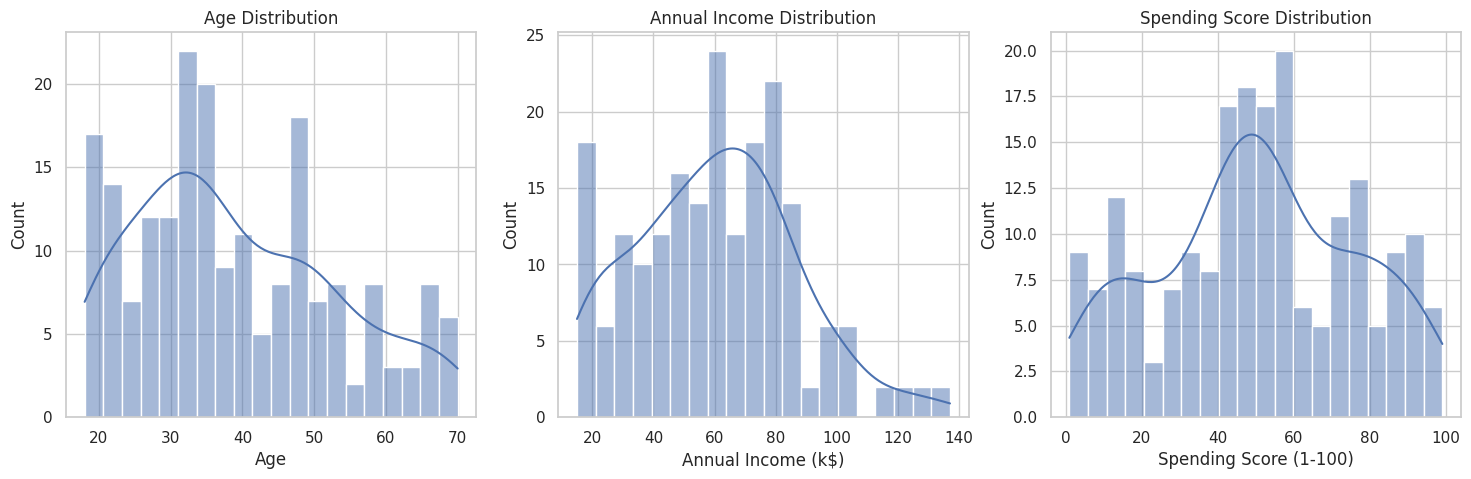

In [ ]:
# Distribution Analysis
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

sns.histplot(df['Age'], bins=20, kde=True, ax=axs[0])
axs[0].set_title('Age Distribution')

sns.histplot(df['Annual Income (k$)'], bins=20, kde=True, ax=axs[1])
axs[1].set_title('Annual Income Distribution')

sns.histplot(df['Spending Score (1-100)'], bins=20, kde=True, ax=axs[2])
axs[2].set_title('Spending Score Distribution')

plt.show()

**Bivariate Analysis**

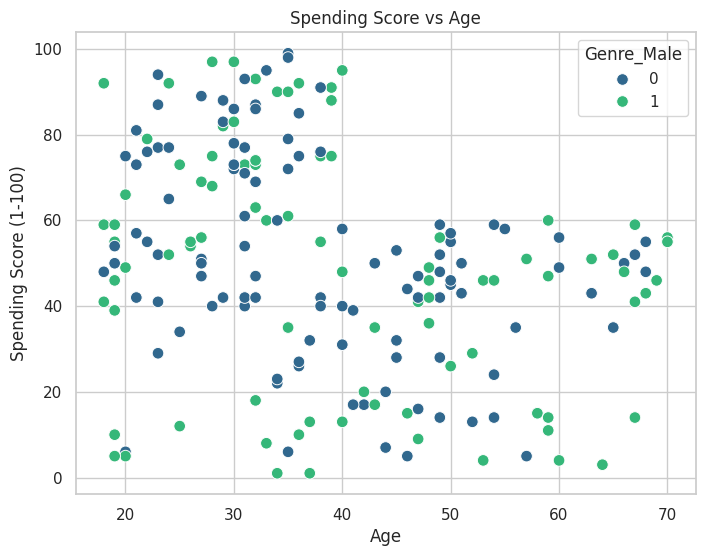

In [ ]:
# Scatter Plot: Age vs. Spending Score
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='Age', y='Spending Score (1-100)', hue='Genre_Male', palette='viridis', s=70)
plt.title('Spending Score vs Age')
plt.xlabel('Age')
plt.ylabel('Spending Score (1-100)')
plt.show()

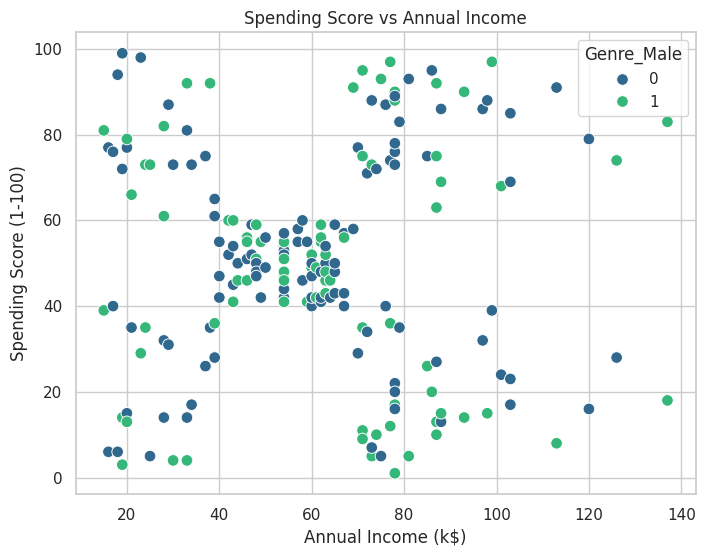

In [ ]:
# Scatter Plot: Annual Income vs. Spending Score
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='Annual Income (k$)', y='Spending Score (1-100)', hue='Genre_Male', palette='viridis', s=70)
plt.title('Spending Score vs Annual Income')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.show()

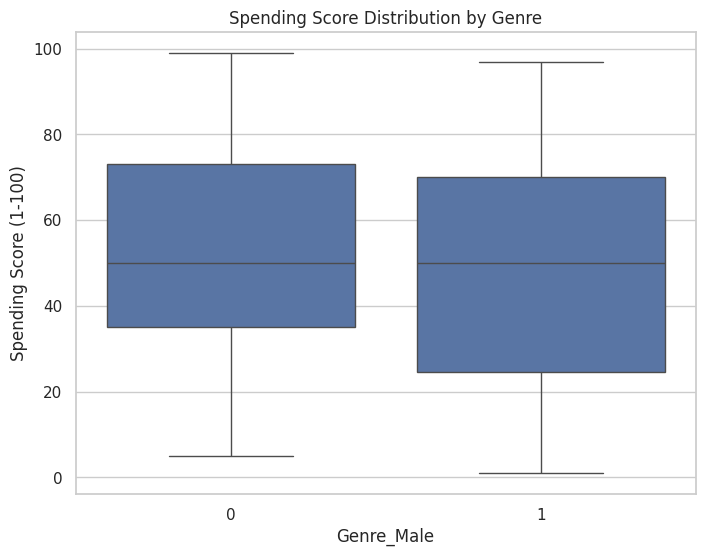

In [ ]:
# Box Plot: Spending Score by Genre
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='Genre_Male', y='Spending Score (1-100)')
plt.title('Spending Score Distribution by Genre')
plt.show()

**Multivariate Analysis**

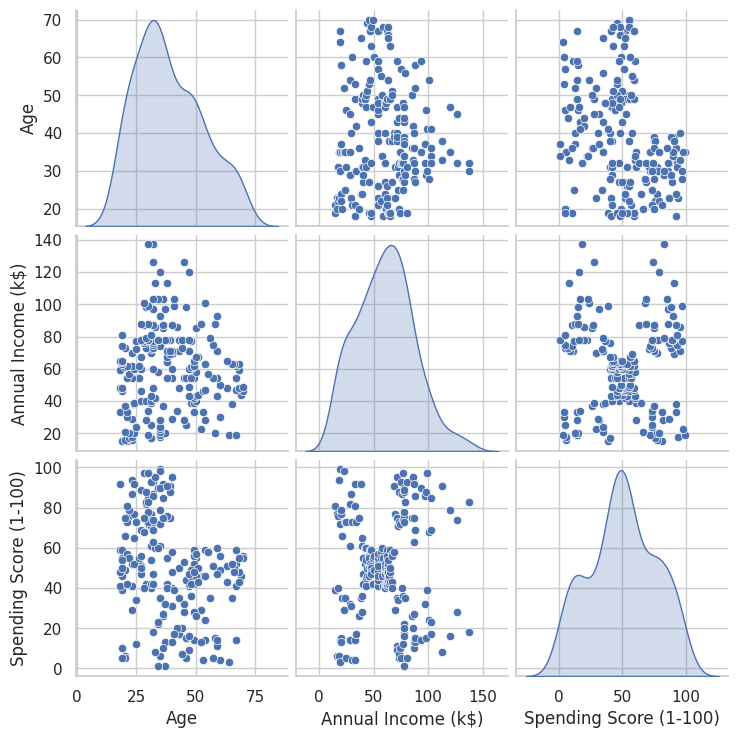

In [ ]:
# Pair Plot: Visualizing Relationships across Multiple Features
sns.pairplot(df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']], diag_kind='kde')
plt.show()

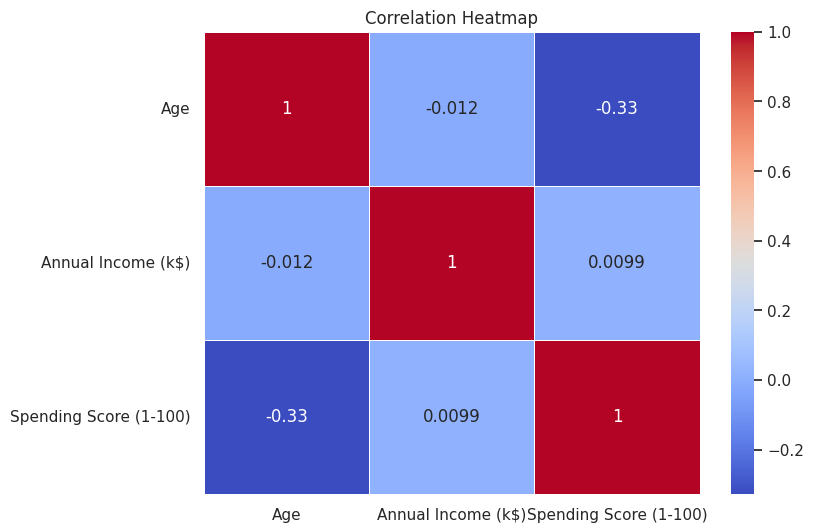

In [ ]:
# Correlation Heatmap (Numerical Features)
plt.figure(figsize=(8, 6))
correlation = df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

**Outlier Checks**

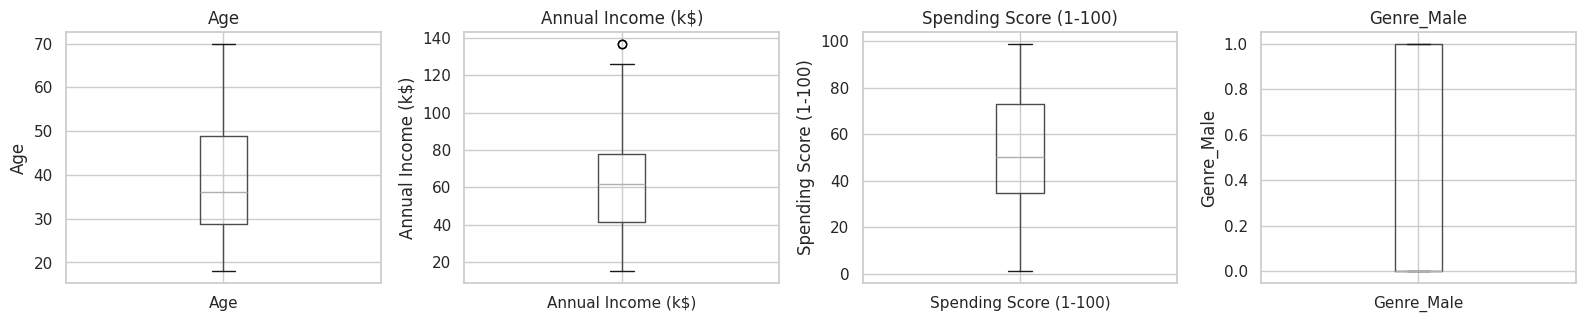

In [ ]:
# draw boxplots to visualize outliers

plt.figure(figsize=(20, 15))
numerical_cols = df.select_dtypes(include=np.number).columns

for i, column in enumerate(numerical_cols):
    plt.subplot(5, 5, i + 1)
    df.boxplot(column=column)
    plt.title(column)
    plt.ylabel(column)

plt.tight_layout()
plt.show()

In [ ]:
def remove_outlier(col) :
  sorted(col)
  Q1,Q3=col.quantile([0.25,0.75])
  IQR=Q3-Q1
  lower_range=Q1-(1.5*IQR)
  upper_range=Q3+(1.5*IQR)
  return lower_range,upper_range

In [ ]:
for column in df.columns:
    lr,ur = remove_outlier(df[column])
    df[column] = np.where(df[column] < lr, lr, df[column])
    df[column] = np.where(df[column] > ur, ur, df[column])

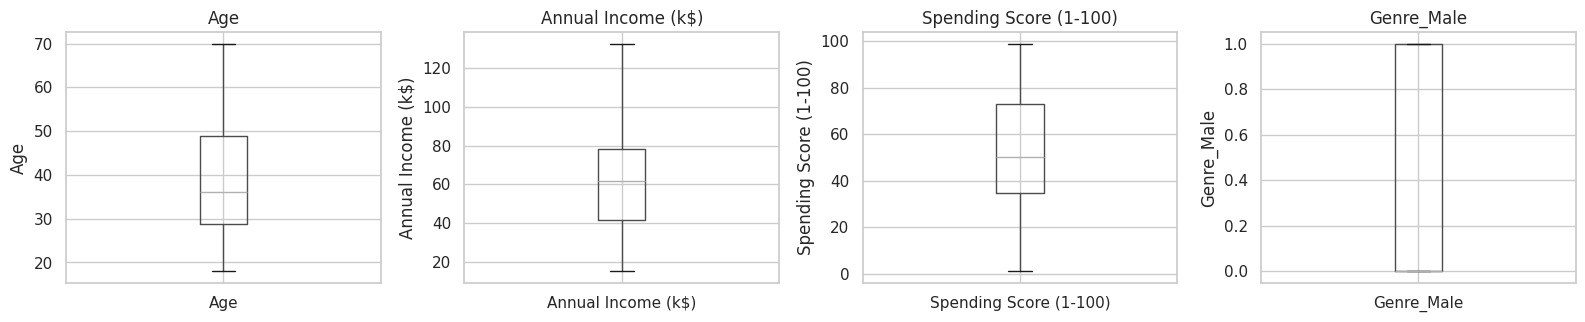

In [ ]:
# draw boxplots to visualize outliers

plt.figure(figsize=(20, 15))
numerical_cols = df.select_dtypes(include=np.number).columns

for i, column in enumerate(numerical_cols):
    plt.subplot(5, 5, i + 1)
    df.boxplot(column=column)
    plt.title(column)
    plt.ylabel(column)

plt.tight_layout()
plt.show()

**Data Scaling**

In [ ]:
# Apply standard scaling
scaler = StandardScaler()

df_scaled = scaler.fit_transform(df)

**Data Modeling**

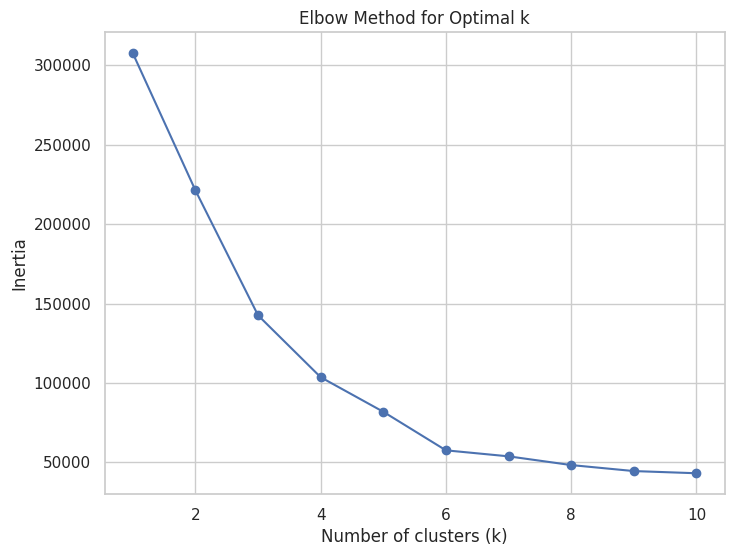

In [ ]:
inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df)
    inertia.append(kmeans.inertia_)

# Elbow Curve
plt.figure(figsize=(8, 6))
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.show()

In [ ]:
# Apply K-means Clustering with k=5

kmeans = KMeans(n_clusters=5, random_state=42)
df['KMeans_Cluster'] = kmeans.fit_predict(df)

In [ ]:
# Calculate silhouette score for K-Means
kmeans_score = silhouette_score(df, kmeans.labels_)
print(f"K-Means Silhouette Score: {kmeans_score:.2f}")

K-Means Silhouette Score: 0.38


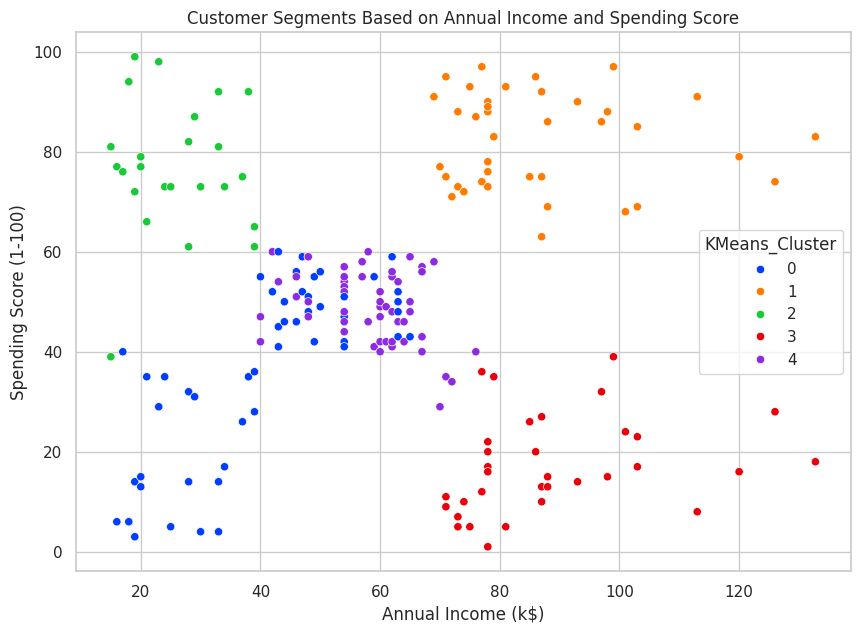

In [ ]:
# Visualize Clusters

plt.figure(figsize=(10, 7))
sns.scatterplot(data=df, x='Annual Income (k$)', y='Spending Score (1-100)', hue='KMeans_Cluster', palette='bright')
plt.title('Customer Segments Based on Annual Income and Spending Score')
plt.show()

In [ ]:
cluster_summary = df.groupby('KMeans_Cluster').agg(
    Average_Age=('Age', 'mean'),
    Average_Income=('Annual Income (k$)', 'mean'),
    Average_Spending_Score=('Spending Score (1-100)', 'mean'),
    Customer_Count=('Age', 'count')
)

cluster_summary

,Average_Age,Average_Income,Average_Spending_Score,Customer_Count
KMeans_Cluster,,,,
0,54.060000,40.460000,36.720000,50
1,32.692308,86.429487,82.128205,39
2,25.250000,25.833333,76.916667,24
3,41.647059,88.610294,16.764706,34
4,33.396226,58.056604,48.773585,53


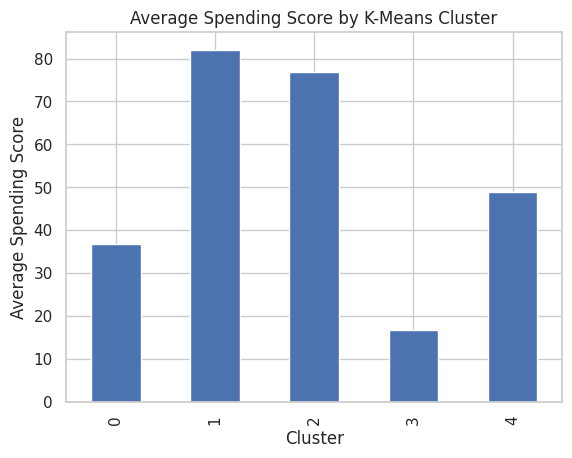

In [ ]:
# Bar plot of average spending score by cluster
df.groupby('KMeans_Cluster')['Spending Score (1-100)'].mean().plot(kind='bar')
plt.title('Average Spending Score by K-Means Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Spending Score')
plt.show()

Agglomerative Clustring

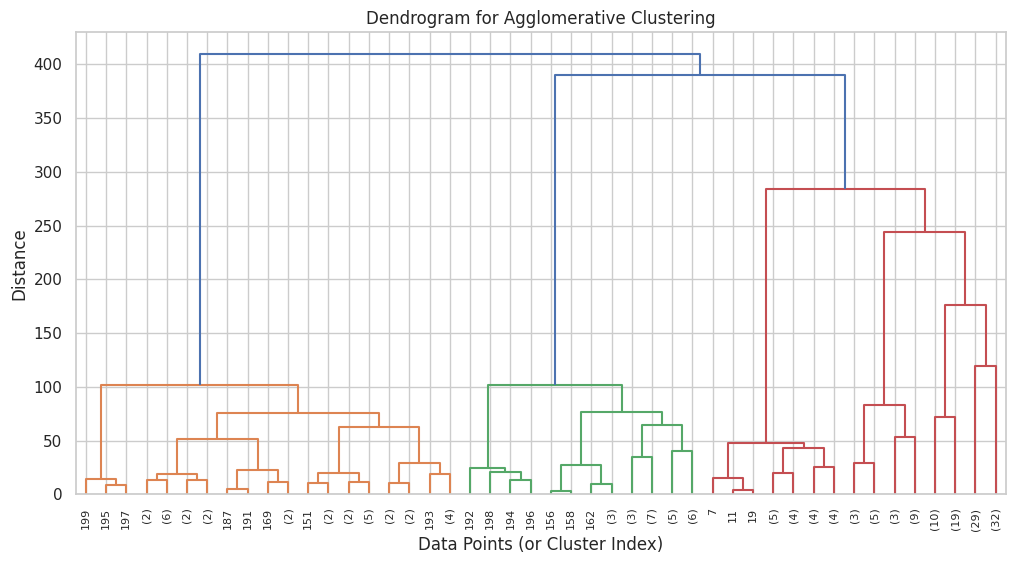

In [ ]:
# Generate the linkage matrix using the 'ward' method
Z = linkage(df, method='ward')

# Plot the dendrogram
plt.figure(figsize=(12, 6))
dendrogram(Z, truncate_mode='level', p=5)  # Truncating for better visibility
plt.title('Dendrogram for Agglomerative Clustering')
plt.xlabel('Data Points (or Cluster Index)')
plt.ylabel('Distance')
plt.show()

In [ ]:
# Apply Agglomerative Clustering with 3 clusters
agg_clustering = AgglomerativeClustering(n_clusters=3, linkage='ward')
df['Agglomerative_Cluster'] = agg_clustering.fit_predict(df)

In [ ]:
# Calculate silhouette score for K-Means
agg_clustering_score = silhouette_score(df, agg_clustering.labels_)
print(f"Agg Clustering Silhouette Score: {agg_clustering_score:.2f}")

Agg Clustering Silhouette Score: 0.37


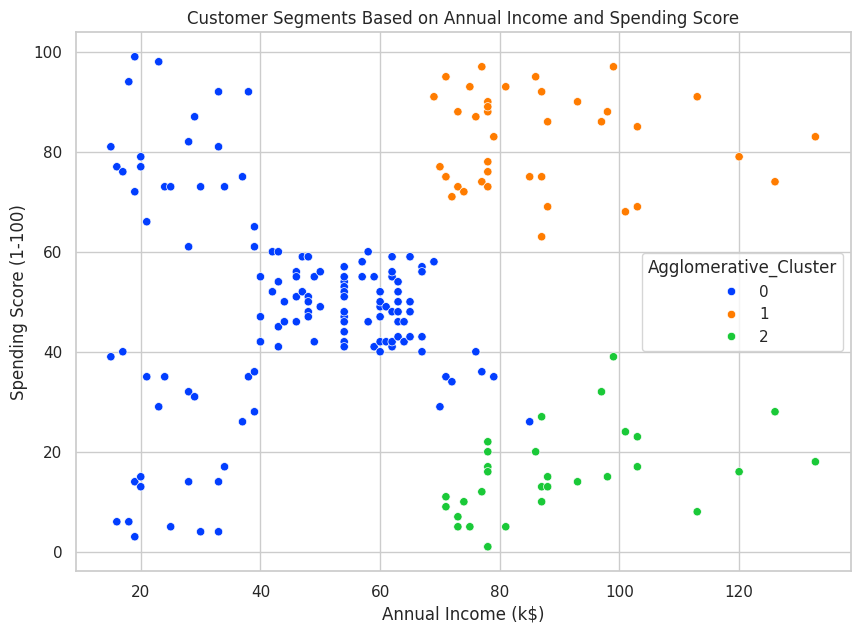

In [ ]:
# Visualize Clusters

plt.figure(figsize=(10, 7))
sns.scatterplot(data=df, x='Annual Income (k$)', y='Spending Score (1-100)', hue='Agglomerative_Cluster', palette='bright')
plt.title('Customer Segments Based on Annual Income and Spending Score')
plt.show()

In [ ]:
cluster_summary = df.groupby('Agglomerative_Cluster').agg(
    Average_Age=('Age', 'mean'),
    Average_Income=('Annual Income (k$)', 'mean'),
    Average_Spending_Score=('Spending Score (1-100)', 'mean'),
    Customer_Count=('Age', 'count')
)

cluster_summary

,Average_Age,Average_Income,Average_Spending_Score,Customer_Count
Agglomerative_Cluster,,,,
0,40.253846,45.853846,48.953846,130
1,32.692308,86.429487,82.128205,39
2,40.709677,89.411290,15.258065,31


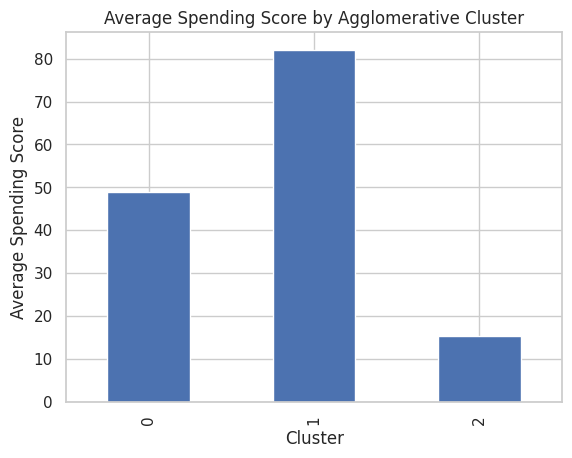

In [ ]:
# Bar plot of average spending score by cluster
df.groupby('Agglomerative_Cluster')['Spending Score (1-100)'].mean().plot(kind='bar')
plt.title('Average Spending Score by Agglomerative Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Spending Score')
plt.show()

## DBSCAN

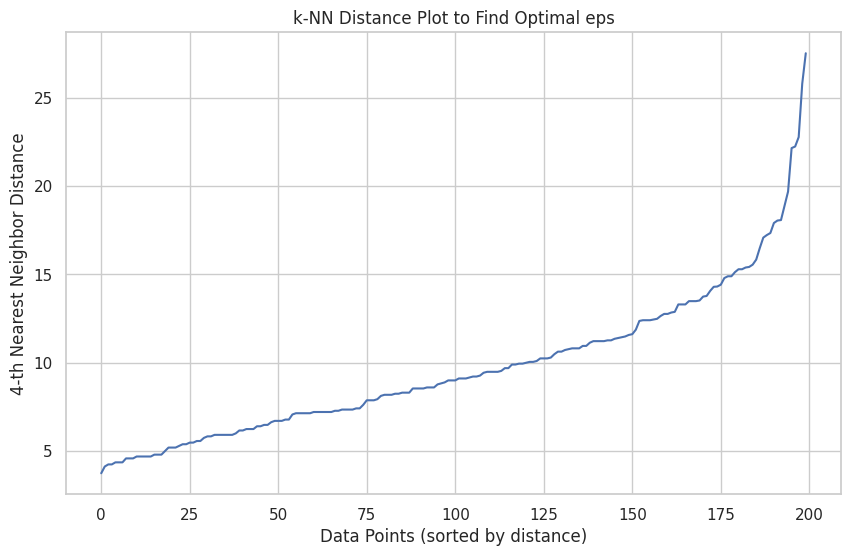

In [ ]:
# Fit Nearest Neighbors model
k = 4  # min_samples - 1
nearest_neighbors = NearestNeighbors(n_neighbors=k)
nearest_neighbors.fit(df)

# Get the distances to the k-nearest neighbors
distances, indices = nearest_neighbors.kneighbors(df)

# Sort the distances for the k-th neighbor
k_distances = np.sort(distances[:, k - 1])

# Plot the k-NN distances
plt.figure(figsize=(10, 6))
plt.plot(k_distances)
plt.title('k-NN Distance Plot to Find Optimal eps')
plt.xlabel('Data Points (sorted by distance)')
plt.ylabel(f'{k}-th Nearest Neighbor Distance')
plt.show()

## Apply DBSCAN



In [ ]:
# Apply DBSCAN
dbscan = DBSCAN(eps=12, min_samples=5)
df['DBSCAN_Cluster'] = dbscan.fit_predict(df)

In [ ]:
dbscan_labels = df['DBSCAN_Cluster']
valid_mask = dbscan_labels != -1  # Boolean mask for valid clusters
valid_features = df[valid_mask]
valid_labels = dbscan_labels[valid_mask]

In [ ]:
# Calculate silhouette score only if there are valid clusters
if len(np.unique(valid_labels)) > 1:
    dbscan_score = silhouette_score(valid_features, valid_labels)
    print(f"DBSCAN Silhouette Score: {dbscan_score:.2f}")
else:
    print("DBSCAN produced too many noise points. No valid clusters found.")

DBSCAN Silhouette Score: 0.34


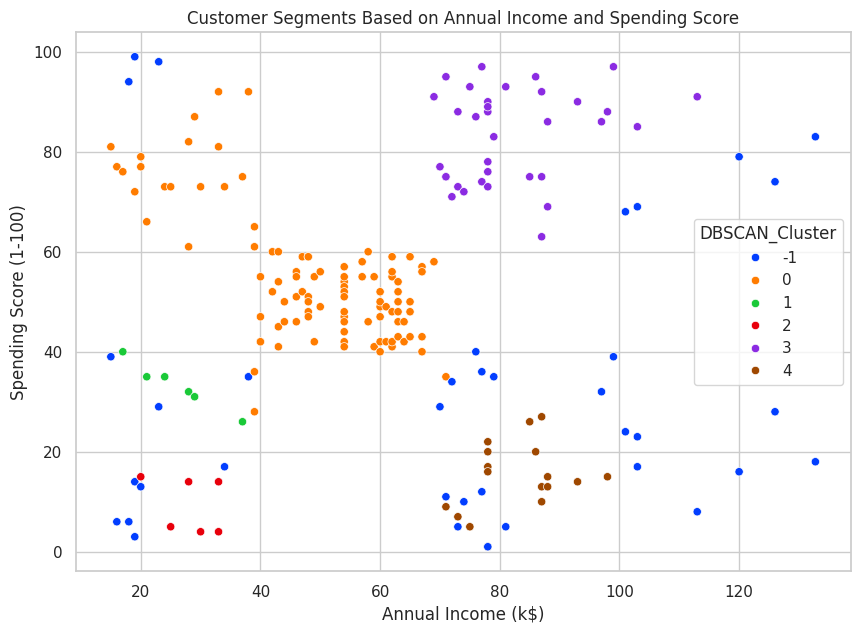

In [ ]:
# Visualize Clusters

plt.figure(figsize=(10, 7))
sns.scatterplot(data=df, x='Annual Income (k$)', y='Spending Score (1-100)', hue='DBSCAN_Cluster', palette='bright')
plt.title('Customer Segments Based on Annual Income and Spending Score')
plt.show()

In [ ]:
cluster_summary = df.groupby('DBSCAN_Cluster').agg(
    Average_Age=('Age', 'mean'),
    Average_Income=('Annual Income (k$)', 'mean'),
    Average_Spending_Score=('Spending Score (1-100)', 'mean'),
    Customer_Count=('Age', 'count')
)

# Display the cluster summary
print("\nCluster Summary:")
cluster_summary


Cluster Summary:


,Average_Age,Average_Income,Average_Spending_Score,Customer_Count
DBSCAN_Cluster,,,,
-1,37.054054,72.094595,33.756757,37
0,39.670000,49.150000,54.560000,100
1,37.000000,26.000000,33.166667,6
2,53.333333,28.166667,9.333333,6
3,32.882353,82.000000,83.235294,34
4,45.411765,82.823529,14.705882,17


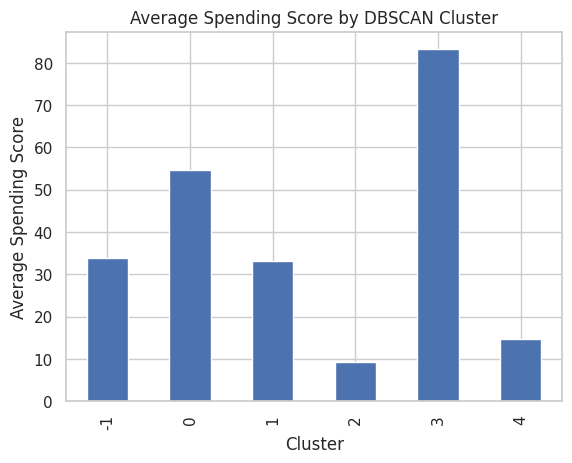

In [ ]:
# Bar plot of average spending score by cluster
df.groupby('DBSCAN_Cluster')['Spending Score (1-100)'].mean().plot(kind='bar')
plt.title('Average Spending Score by DBSCAN Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Spending Score')
plt.show()

In [ ]:
df = df.drop(columns=['Agglomerative_Cluster', 'DBSCAN_Cluster'])
df.head()

,Age,Annual Income (k$),Spending Score (1-100),Genre_Male,KMeans_Cluster
0,19.0,15.0,39.0,1.0,2
1,21.0,15.0,81.0,1.0,2
2,20.0,16.0,6.0,0.0,0
3,23.0,16.0,77.0,0.0,2
4,31.0,17.0,40.0,0.0,0
